<a href="https://colab.research.google.com/github/gchurakov/steps2buildAI/blob/main/sales_analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math

from scipy import stats

import matplotlib.pyplot as plt

import statsmodels.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# Dataset
The file contains historic sales for a DIY retail store.

The columns:
- **date** - date (granularity is weekly),
- **item** - product name,
- **category** - product category

    (Product categories: **"Грунтовка"**, **"Сухие смеси"** and **"Напольные покрытия"**),
- **quantity** - number of items sold.


Each row corresponds to total sales for a specified item for a specified week.

## (!) Note that it is possible that some items didn't sell during some weeks.



In [ ]:
df = pd.read_csv("/content/materials.txt", encoding='Windows-1251', sep='\t')
# df.date = pd.to_datetime(df.date, format='%d.%m.%Y')
print(df.shape)

(7420, 4)


Считан файл и верно раскодирован, так как дальше нужно будет аггрегировать данные помесячно, заменим день на 01 во всех сэмплах, можно было и обрезать его, но дальше нужно будет обрабатывать временной ряд, поэтому оставим его и переведем в формат ДатА

In [ ]:
transform = lambda date: '01.' + date[3:]
print(transform(df.date[0]))

01.07.2004


In [ ]:
df.date = df.date.apply(transform)
df.date = pd.to_datetime(df.date, format='%d.%m.%Y')
df.head()

,date,item,category,quantity
0,2004-07-01,Грунтовка алкидная ГФ-021 ТЕКС Универсал красн...,Грунтовка,838
1,2004-07-01,"Грунтовка вд ОПТИМИСТ для нар/ внутр. работ, ж...",Грунтовка,394
2,2004-07-01,Грунтовка алкидная ГФ-021 ТЕКС Универсал красн...,Грунтовка,936
3,2004-07-01,"Грунтовка вд ОПТИМИСТ для нар/ внутр. работ, ж...",Грунтовка,106
4,2004-07-01,Грунтовка алкидная ГФ-021 ТЕКС Универсал красн...,Грунтовка,32


In [ ]:
df.dtypes

date        datetime64[ns]
item                object
category            object
quantity             int64
dtype: object

In [ ]:
print("Уникальные категории товаров:", ', '.join(df.category.unique()), end='.')

Уникальные категории товаров: Грунтовка, Напольные покрытия, Сухие смеси.

In [ ]:
for c in df.columns:
    print(f"В столбце {c} есть {sum(df[c].isna())} пустых значений")

В столбце date есть 0 пустых значений
В столбце item есть 0 пустых значений
В столбце category есть 0 пустых значений
В столбце quantity есть 0 пустых значений


# The aim is to calculate a monthly forecast for each product category.
1. Aggregate sales into monthly periods. Fill in the gaps in data, if necessary.


2. Use the last 6 months as a testing period, the remaining data as a training period


3. Explore the regular components of the historic sales series for each category.

    Based on the results of the exploratory analysis, choose at least two suitable forecasting models for each category.


4. Build your chosen models for each category on the training data.
    
    Calculate forecasts for the test period (last 6 months).


5. Assess the performance of your models using the test period.

    Calculate MAE, MAPE, RMSE and BIAS metrics for each forecast.

    Choose the best model for each category using MAPE metric.

визуализируем данные

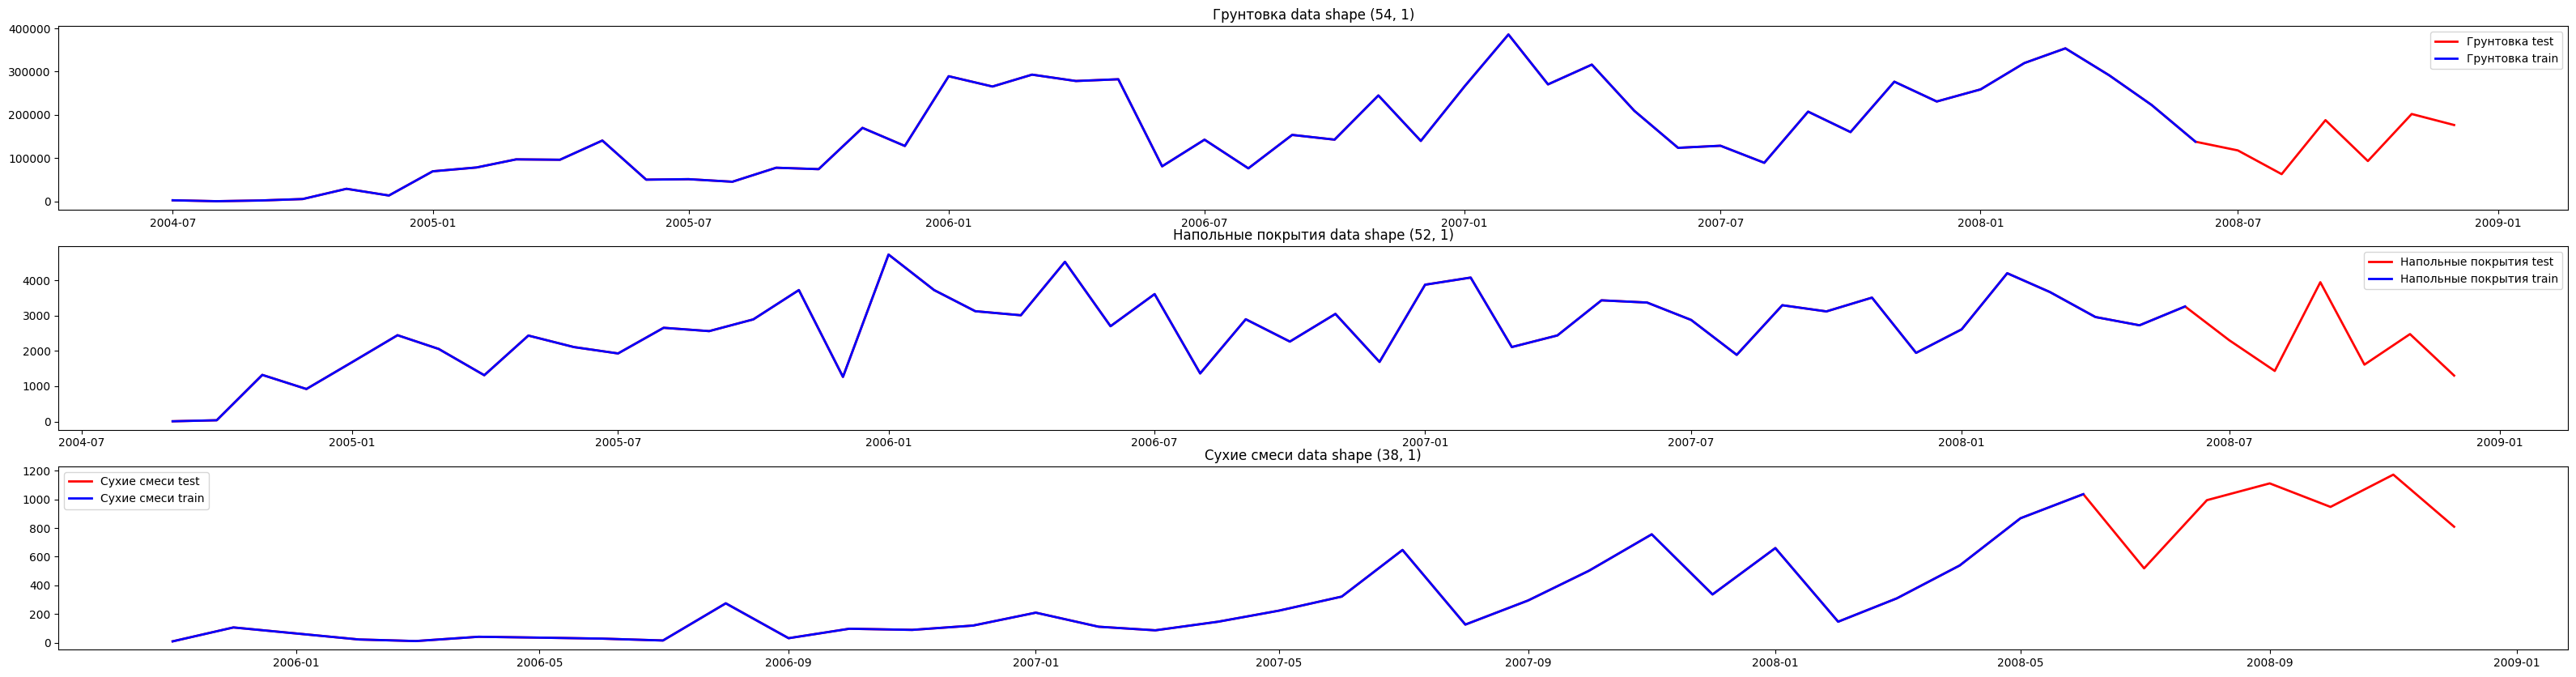

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(40,10))

for i, c in enumerate(df.category.unique()):
    grouped = df[df.category==c].groupby('date').sum()
    ax[i].set_prop_cycle(color=["red", "blue", "gold", "darkorange", "tomato"])
    ax[i].set_title(f"{c} data shape {grouped.shape}")

    ax[i].plot(grouped[:], linewidth=2, label=f'{c} test')
    ax[i].plot(grouped[:-6], linewidth=2, label=f'{c} train')

    ax[i].legend(loc="best")
plt.show()

Используем Метод скользящего окна и Экспоненциального сглаживания для предобработки данных

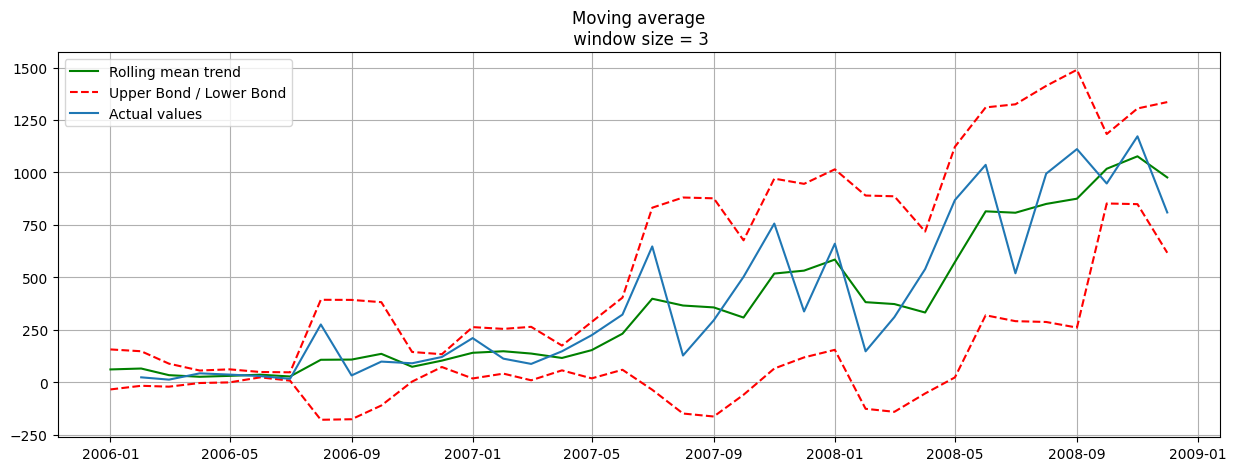

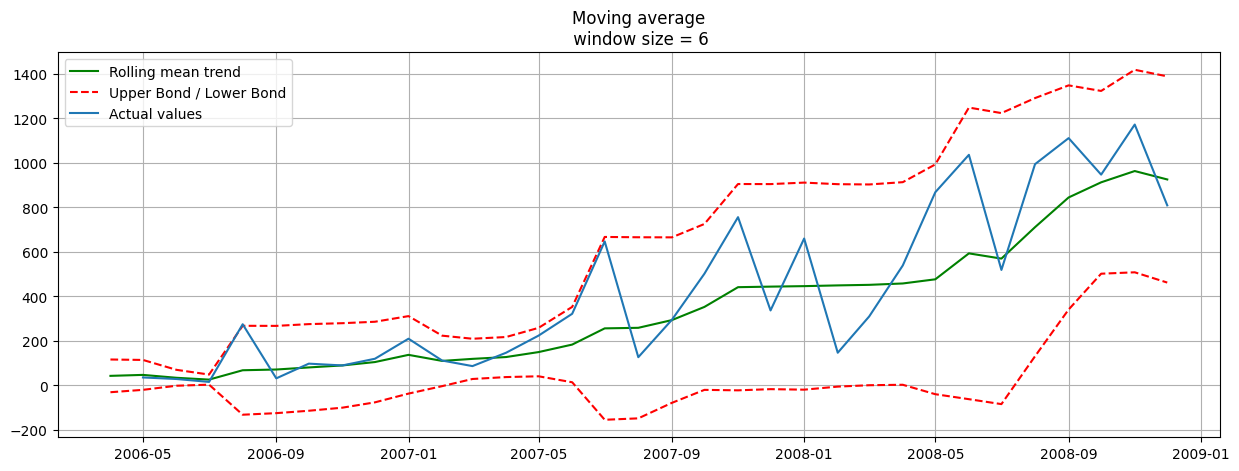

In [ ]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size

    """

    rolling_mean = series.rolling(window=n).mean()

    # Доверительные интервалы
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(grouped[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


plotMovingAverage(grouped.quantity, 3)
plotMovingAverage(grouped.quantity, 6)

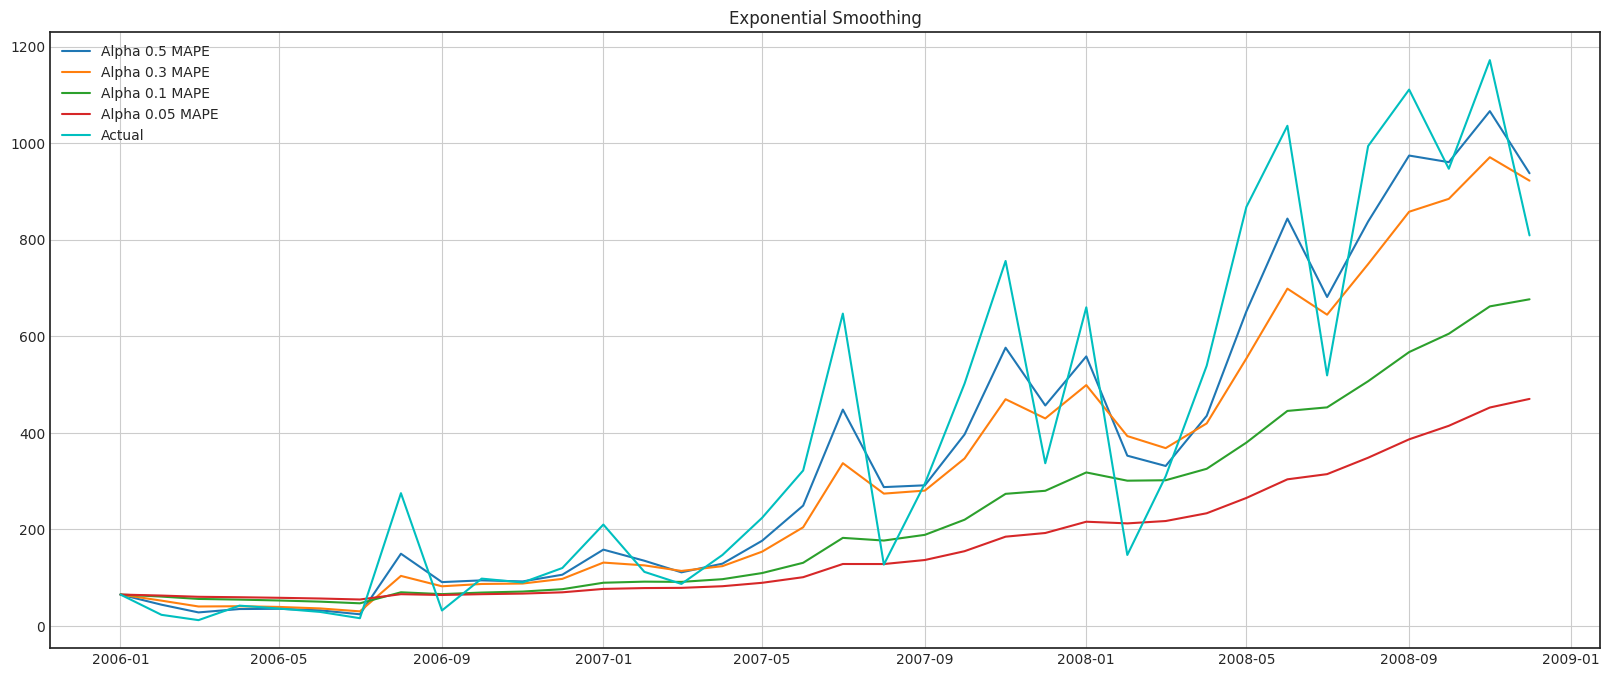

In [ ]:
def exponential_smoothing(series, alpha):
    series = series.to_numpy()
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.5, 0.3, 0.1, 0.05]:
        res = exponential_smoothing(grouped.quantity, alpha)
        plt.plot(grouped.index, res, label="Alpha {} MAPE ".format(alpha))
    plt.plot(grouped.quantity, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

Проверка на стационарность тестом  Дики-Фуллера

- `pval -> 1 - ряд НЕстационарный`
- `pval -> 0 - ряд стационарный`

1. Ряд не стационарный
2. Присутствует автокорреляция

существуют методы борьбы со стационарностью, напимер переходам к разностью, но не очень понятно, как от предсказаний для стационарного ряда перейти к предсказаниям для исходного ряда

Критерий Дики-Фуллера: p=0.999066


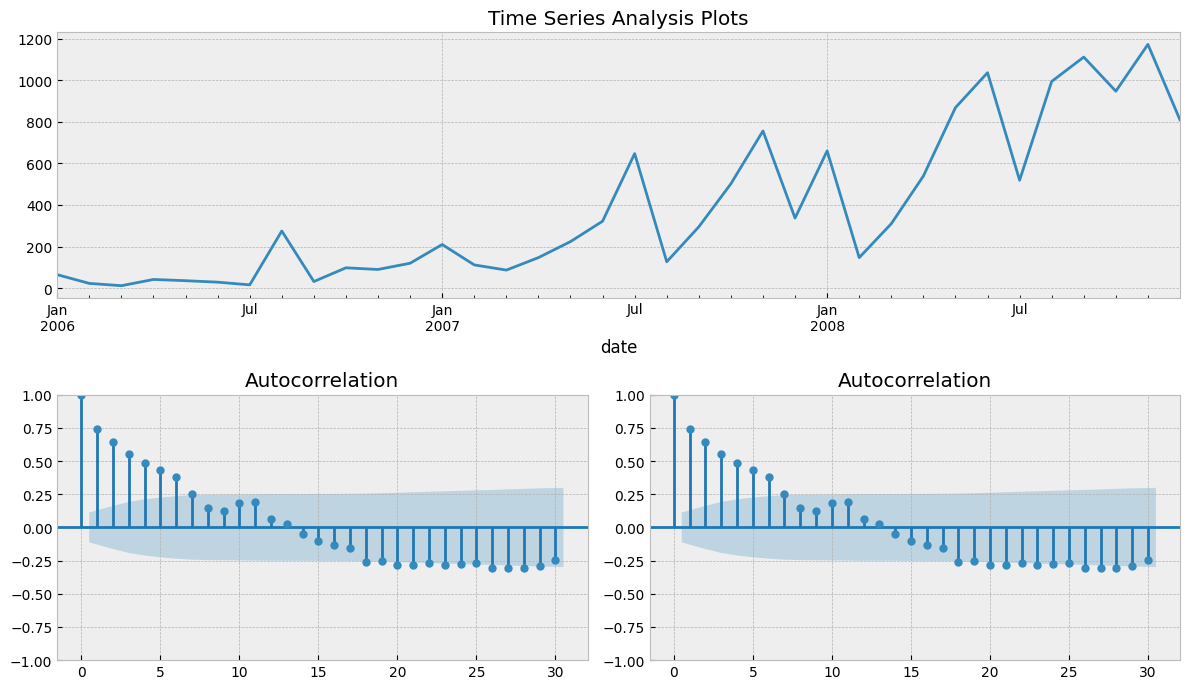

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')

        smt.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.tsa.plot_acf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % smt.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

tsplot(grouped.quantity, lags=30)

Критерий Дики-Фуллера: p=0.923459
Оптимальный параметр преобразования Бокса-Кокса: 0.179518


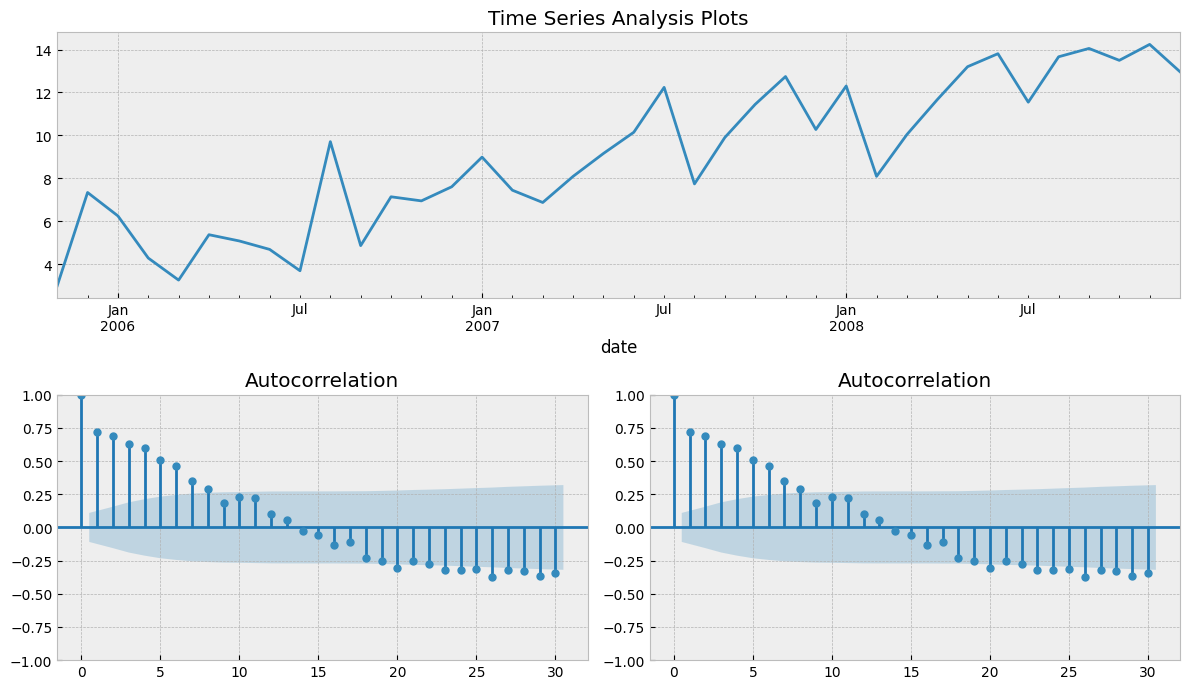

In [ ]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = grouped.copy()
data['box'], lmbda = stats.boxcox(data.quantity+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

1. убираем из ряда сезонную и шумовую составляющие

Критерий Дики-Фуллера: p=0.000000


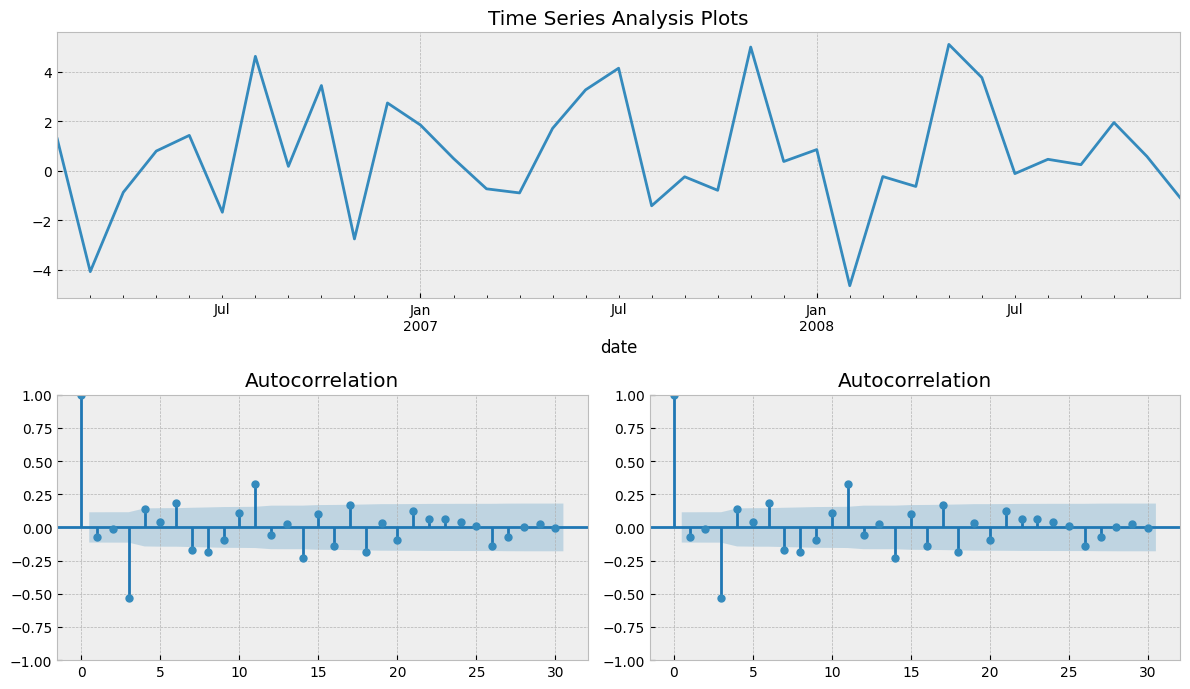

In [ ]:
data['box_season'] = data.box - data.box.shift(3)
tsplot(data.box_season[3:], lags=30)

Ряд облатает сильной сезонной компонентой, тренд восходящий

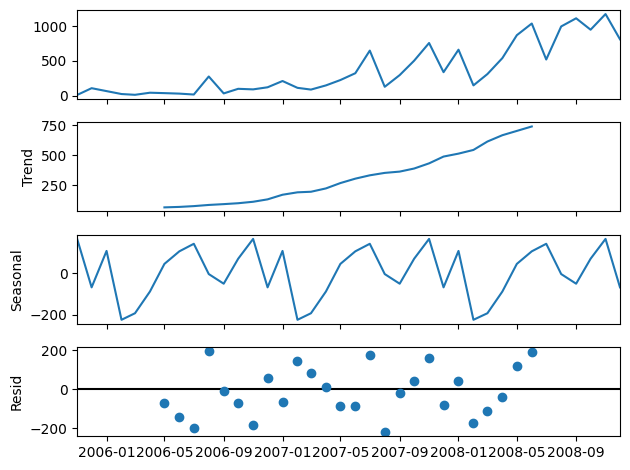

In [ ]:
seasonal_decompose(grouped, model='additive').plot()


# Task (advanced): detailed forecast, +1 point
Aggregate forecasts are useful to budget sales and to perform capacity planning. However, the inventory management process requires detailed, item-level forecasts

In this task, you are required

1. Calculate the detailed forecast for the monthly demand for each item.
    
    (!) Note that the direct approach, when you perform the forecasting for each item, probably will yield poor results.
    
    The item-level data has many gaps, and models won't work with it.

    One viable approach is to split the category-level forecast down to the item level using historic shares of items in each category.
    
    You can calculate these shares using Python's pandas library and apply them to the category-level forecast.

2. Create an item-level forecasts for each item for the testing period (last 6 months).

3. Calculate error metrics for each item.

4. Plot the histogram of MAPE values for all items.
    
    What are the best and the worst pertorming items in terms of МАРЕ?


# Task (advanced): automated model-selection, +1 point
In this task, you are required:

1. Automate the entire forecasting process.
    
    You must write code that would automatically:
    - pick the best model
    - create a 12-month forecast for each category available in the data.

Write your code with the assumption that the number of categories can be arbitrary and can change.

The code must use all available data to create the forecast.

For model selection, you can use some testing period internally, but the best model must be re-fit using all the data before creating a 12-month forecast.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [ ]:
# metrics
scoring = {
    'mse': lambda y_true, y:  np.mean(np.power(y - y_true, 2)),
    'mae': lambda y_true, y:  np.mean(np.abs(y - y_true)),
    'rmse': lambda y_true, y: np.sqrt(np.mean((y - y_true) ** 2)),
    'mape': lambda y_true, y: np.mean(np.abs((y_true - y) / y_true)) * 100,
    'bias': lambda y_true, y: np.mean(y) - np.mean(y_true)
}


Добваим в батасет features для многопараметрической регрессии

- среднее за время года
- предыдушие 2 значения
- разность между жвумя предыдущими значениями

==============================Грунтовка==============================

 ------------------------------ Linear ------------------------------
mse : 4616215068.634
mae : 62400.389
rmse : 67942.734
mape : 48.452
bias : 2304.288

 ------------------------------ SVR ------------------------------
mse : 2303621388.604
mae : 42412.774
rmse : 47996.056
mape : 39.473
bias : 2933.216

 ------------------------------ LR ------------------------------
mse : 9992235807.429
mae : 68617.429
rmse : 99961.171
mape : 76.418
bias : 41613.143

 ------------------------------ RF ------------------------------
mse : 4304667487.729
mae : 55058.363
rmse : 65609.965
mape : 55.73
bias : 18665.327
 Best Estimator: SVR
==============================Напольные покрытия==============================

 ------------------------------ Linear ------------------------------
mse : 760354.608
mae : 713.219
rmse : 871.983
mape : 33.955
bias : 157.537

 ------------------------------ SVR ------------------------------
mse : 

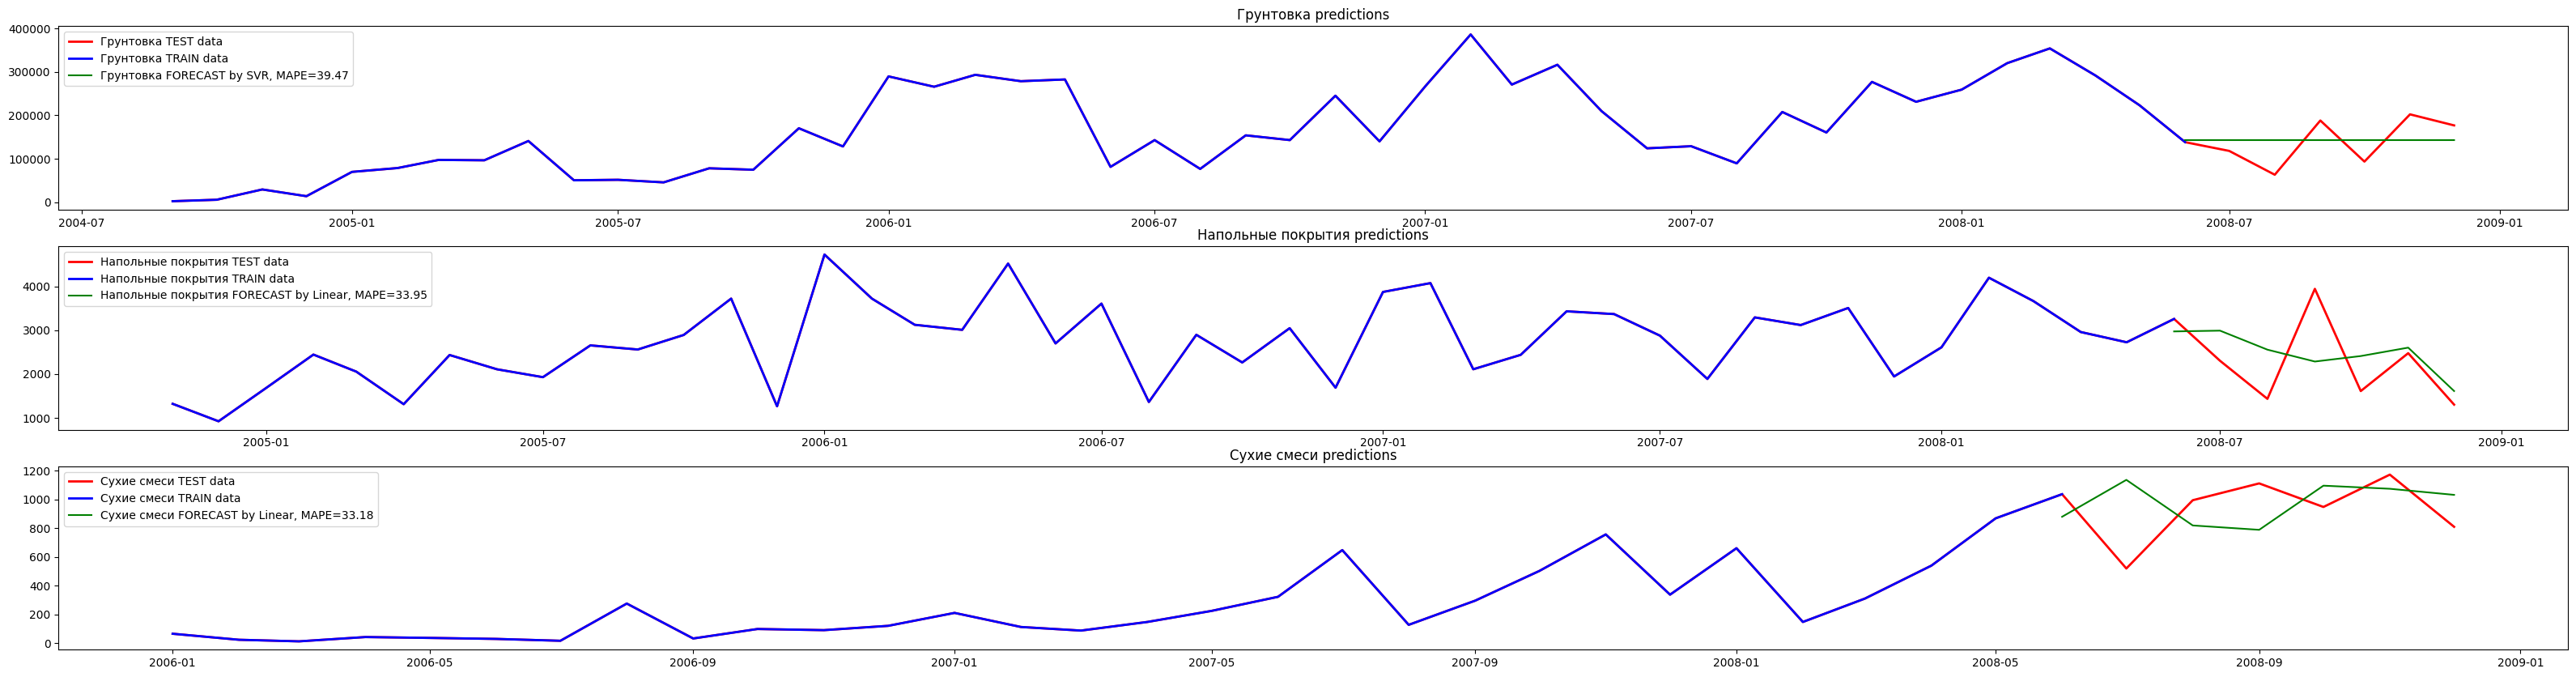

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(40,10))

# creating regressor for each category
for i, c in enumerate(df.category.unique()):

    grouped = df[df.category==c].groupby('date').sum()

    grouped['season'] = grouped.index
    grouped['season'] = grouped.season.apply(lambda x: int(str(x)[5:7])//4+1)
    season_mean = grouped[:-6].groupby('season').quantity.mean().to_dict()# считаем среднее только на TRAIN
    grouped['season'] = grouped.season.apply(lambda x: season_mean[x])

    grouped['log1'] = grouped.quantity.shift(1)
    grouped['log2'] = grouped.log1.shift(1)
    grouped = grouped.dropna(axis=0)
    grouped['logs_diff'] = grouped.log2 - grouped.log1

    models = {\
        'Linear' : LinearRegression(),\
        'SVR' : SVR(degree=3),\
        'LR' : LogisticRegression(),\
        'RF' : RandomForestRegressor(max_depth=6, n_estimators=100, random_state=42)
    }

    results = {name: {} for name in models}

    # config data

    x_train = grouped[:-6].drop('quantity', axis=1)
    x_test = grouped[-7:].drop('quantity', axis=1)
    y_train, y_test = grouped.quantity[:-6], grouped.quantity[-7:]


    # fit and score models
    print('='*80, "="*30 + c + "="*30, sep='\n')

    for name, model in models.items():

        print('\n', '-'*30, name, '-'*30)
        model.fit(x_train, y_train)

        predicted = model.predict(x_test)

        for metric, scorer in scoring.items():
            results[name][metric] = scorer(y_test, predicted)
            print(f"{metric} : {round(results[name][metric], 3)}")


    # # pick best estimator re-fit-predict and evualate
    best_estimator_name = min(results, key=lambda x: results[x]['mape'])# select regressor by MAPE score
    best_estimator = models[best_estimator_name]
    best_estimator.fit(x_train, y_train)

    # x_predict = pd.DataFram
    predicted_by_best = best_estimator.predict(x_test)

    best_estimator_lagend = f"\nBest Estimator: {best_estimator_name}\nTest Set Metrics: {results[best_estimator_name]}"
    print(*best_estimator_lagend.split('\n')[:2])

    # # plot
    ax[i].set_title(f"{c} predictions")

    # # plot data
    x_all = np.arange(1, len(grouped)+1, 1)
    ax[i].plot(grouped.quantity, linewidth=2, label=f'{c} TEST data', color='red')
    ax[i].plot(y_train, linewidth=2, label=f'{c} TRAIN data', color='blue')
    ax[i].plot(y_test.index, predicted_by_best, label=f"{c} FORECAST by {best_estimator_name}, MAPE={round(results[best_estimator_name]['mape'],2)}", color='green')



    # # plot predictions
    ax[i].legend(loc="upper left")

plt.show()



формирование данных для предсказания

In [ ]:
grouped = df[df.category==df.category[0]].groupby('date').sum()

grouped['season'] = grouped.index
grouped['season'] = grouped.season.apply(lambda x: int(str(x)[5:7])//4+1)
season_mean = grouped[:-6].groupby('season').quantity.mean().to_dict()# считаем среднее только на TRAIN
grouped['season'] = grouped.season.apply(lambda x: season_mean[x])

grouped['log1'] = grouped.quantity.shift(1)
grouped['log2'] = grouped.log1.shift(1)
grouped = grouped.dropna(axis=0)
grouped['logs_diff'] = grouped.log2 - grouped.log1

models = {\
    'Linear' : LinearRegression(),\
    'SVR' : SVR(degree=3),\
    'LR' : LogisticRegression(),\
    'RF' : RandomForestRegressor(max_depth=6, n_estimators=100, random_state=42)
}

results = {name: {} for name in models}

# config data

x_train = grouped[:-6].drop('quantity', axis=1)
x_test = grouped[-7:].drop('quantity', axis=1)
y_train, y_test = grouped.quantity[:-6], grouped.quantity[-7:]

In [ ]:
# x_predict_index = ['2008-06-01', '2008-07-01', '2008-08-01', '2008-09-01',\
#                '2008-10-01', '2008-11-01', '2008-12-01', '2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',\
#                '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01', '2009-09-01',\
#                '2009-10-01', '2009-11-01', '2009-12-01']

# data = x_train[-2:]
# data['date'] = data.index

# x_predict = pd.DataFrame(x_predict_index, columns=['date'])
# x_predict = pd.concat([data,x_predict], axis=0)
# # x_predict['season'] = x_predict.date
# # x_predict['season'] = x_predict.season.apply(lambda x: int(str(x)[5:7])//4+1)
# # x_predict['log1'] = x_predict.quantity.shift(1)
# # x_predict['log2'] = x_predict.log1.shift(1)
# # x_predict = x_predict.dropna(axis=0)
# # x_predict['logs_diff'] = x_predict.log2 - x_predict.log1
# x_predict



Попробуем применить к данным экспоненциальное сглаживание

==============================Грунтовка==============================

 ------------------------------ Linear ------------------------------
mse : 29144986574.808
mae : 164151.072
rmse : 170719.028
mape : 156.667
bias : 164151.072

 ------------------------------ SVR ------------------------------
mse : 3377379312.941
mae : 48696.536
rmse : 58115.224
mape : 53.075
bias : 26465.706

 ------------------------------ RF ------------------------------
mse : 12387565156.053
mae : 98542.79
rmse : 111299.439
mape : 102.819
bias : 98542.79
 Best Estimator: SVR
==============================Напольные покрытия==============================

 ------------------------------ Linear ------------------------------
mse : 3392213.45
mae : 1659.395
rmse : 1841.796
mape : 101.959
bias : 1593.794

 ------------------------------ SVR ------------------------------
mse : 1117770.492
mae : 957.657
rmse : 1057.247
mape : 54.955
bias : 553.177

 ------------------------------ RF ------------------------------
m

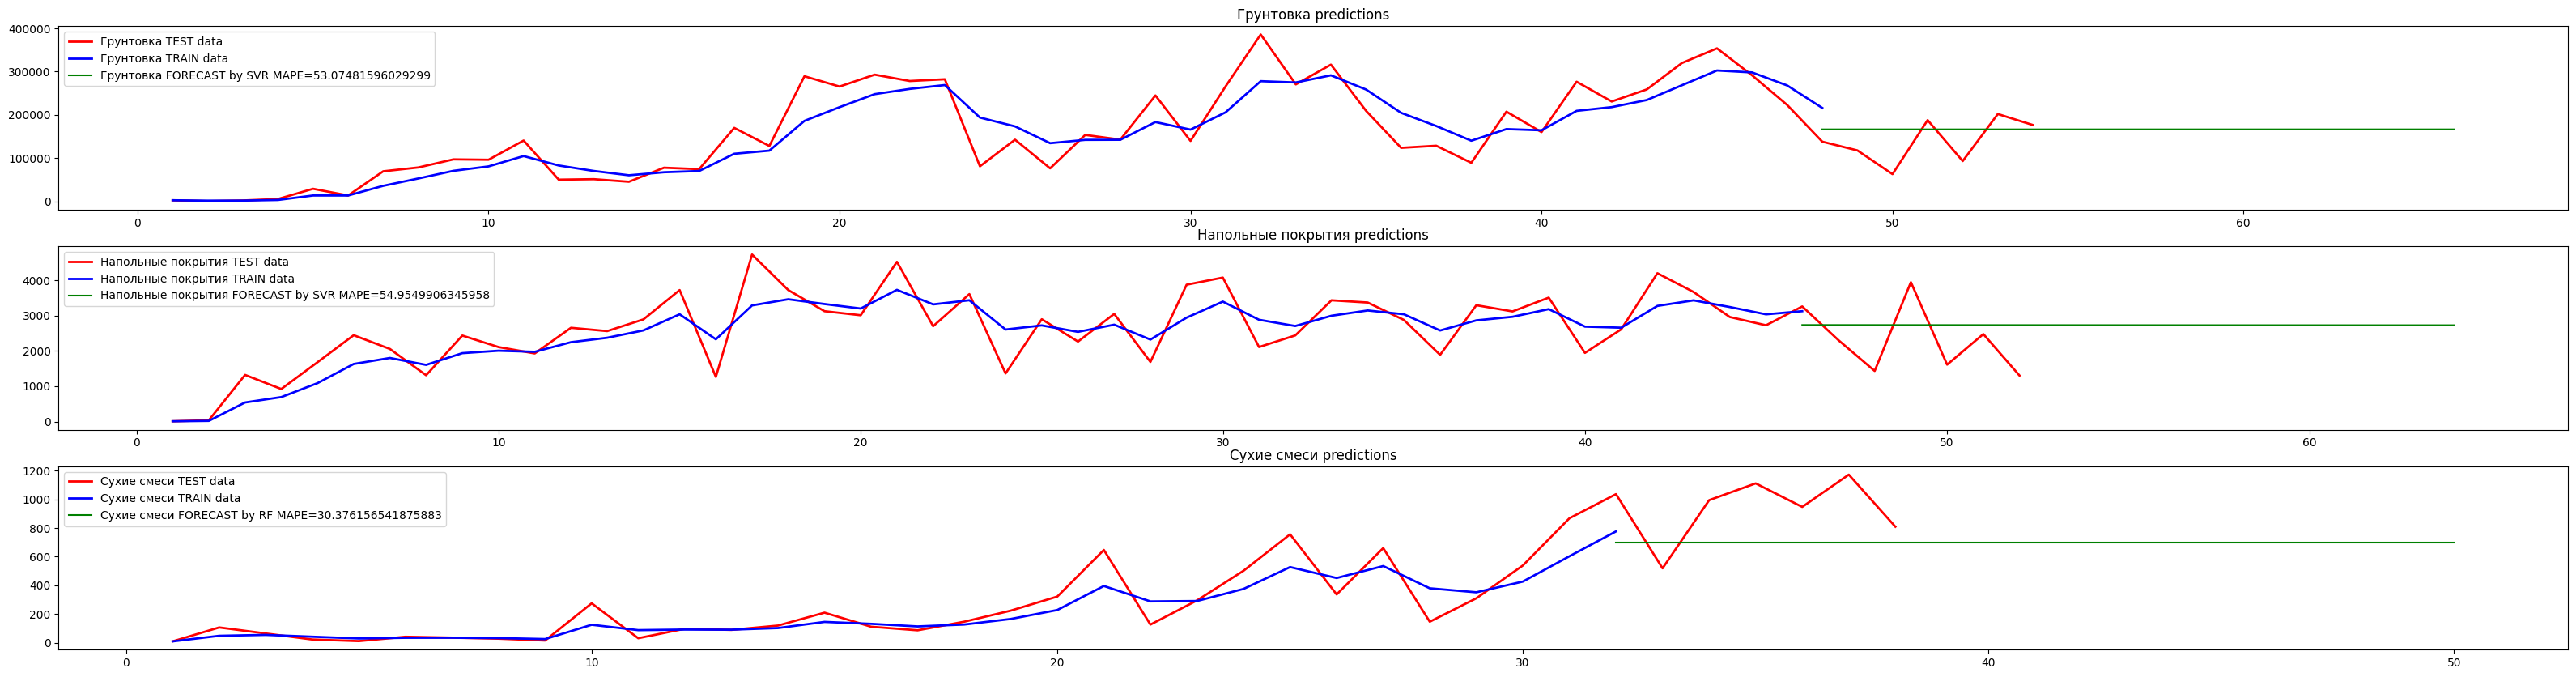

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(40,10))

# creating regressor for each category
for i, c in enumerate(df.category.unique()):
    grouped = df[df.category==c].groupby('date').sum()
    smoothed = pd.DataFrame(exponential_smoothing(grouped.quantity, 0.4))

    models = {\
        'Linear' : LinearRegression(),\
        'SVR' : SVR(degree=3),\
        # 'LR' : LogisticRegression(),\
        'RF' : RandomForestRegressor(max_depth=6, n_estimators=100, random_state=42)
    }

    results = {name: {} for name in models}

    # config data
    x_train = np.arange(1, len(grouped)-6+1, 1).reshape(len(grouped)-6, 1)
    x_test = np.arange(len(grouped)-6+1, len(grouped)+1, 1).reshape(6, 1)
    x_predict = np.arange(len(grouped)-6, len(grouped)+1+12, 1).reshape(6+13, 1)

    y_train, y_test = smoothed[:-6], grouped[-6:]


    # fit and score models
    print('='*80, "="*30 + c + "="*30, sep='\n')

    for name, model in models.items():

        print('\n', '-'*30, name, '-'*30)
        model.fit(x_train, y_train)

        predicted = model.predict(x_test)

        for metric, scorer in scoring.items():
            results[name][metric] = scorer(y_test.quantity, predicted.reshape(6,))
            print(f"{metric} : {round(results[name][metric], 3)}")


    # pick best estimator re-fit-predict and evualate
    best_estimator_name = min(results, key=lambda x: results[x]['mape'])# select regressor by MAPE score
    best_estimator = models[best_estimator_name]
    best_estimator.fit(x_train, y_train)


    predicted_by_best = best_estimator.predict(x_predict)

    best_estimator_lagend = f"\nBest Estimator: {best_estimator_name}\nTest Set Metrics: {results[best_estimator_name]}"
    print(*best_estimator_lagend.split('\n')[:2])

    # plot
    ax[i].set_title(f"{c} predictions")

    # plot data
    x_all = np.arange(1, len(grouped)+1, 1)
    ax[i].plot(x_all, grouped.values, linewidth=2, label=f'{c} TEST data', color='red')
    ax[i].plot(x_train, y_train, linewidth=2, label=f'{c} TRAIN data', color='blue')
    ax[i].plot(x_predict, predicted_by_best, label=f"{c} FORECAST by {best_estimator_name} MAPE={results[best_estimator_name]['mape']}", color='green')



    # plot predictions

    ax[i].legend(loc="upper left")

plt.show()




 Попробуем сгладить данные при помощи скользящего окна

==============================Грунтовка==============================

 ------------------------------ Linear ------------------------------
mse : 29045173980.351
mae : 163820.838
rmse : 170426.447
mape : 156.428
bias : 163820.838

 ------------------------------ SVR ------------------------------
mse : 3322580681.046
mae : 48696.427
rmse : 57641.831
mape : 52.738
bias : 25409.535

 ------------------------------ RF ------------------------------
mse : 18847129606.812
mae : 127162.282
rmse : 137284.848
mape : 127.139
bias : 127162.282
 Best Estimator: SVR
==============================Напольные покрытия==============================

 ------------------------------ Linear ------------------------------
mse : 2698663.95
mae : 1503.662
rmse : 1642.761
mape : 91.52
bias : 1363.57

 ------------------------------ SVR ------------------------------
mse : 1319701.434
mae : 1063.984
rmse : 1148.783
mape : 62.058
bias : 712.652

 ------------------------------ RF ------------------------------

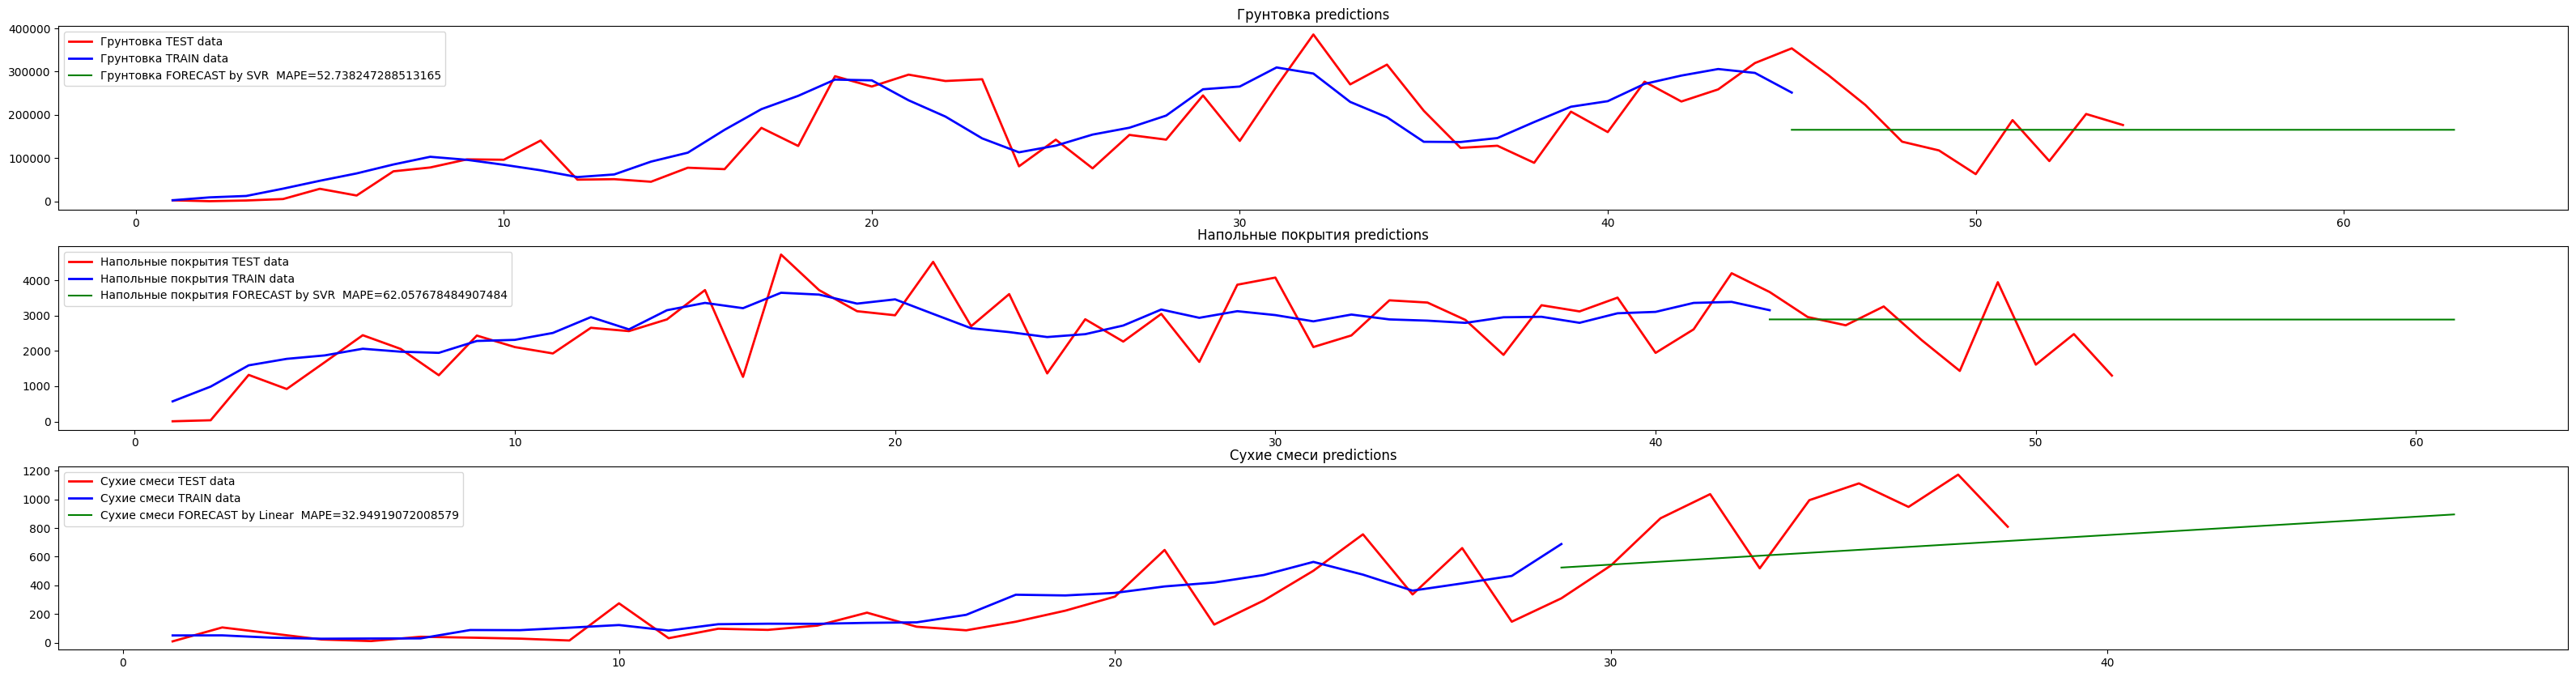

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(40,10))

# creating regressor for each category
for i, c in enumerate(df.category.unique()):
    n=4
    grouped = df[df.category==c].groupby('date').sum()
    rolled = grouped.quantity.rolling(window=n).mean().dropna(axis=0)

    models = {\
        'Linear' : LinearRegression(),\
        'SVR' : SVR(degree=3),\
        # 'LR' : LogisticRegression(),\
        'RF' : RandomForestRegressor(max_depth=6, n_estimators=100, random_state=42)
    }

    results = {name: {} for name in models}

    # config data
    x_train = np.arange(1, len(rolled)-6+1, 1).reshape(len(rolled)-6, 1)
    x_test = np.arange(len(rolled)-6+1, len(rolled)+1, 1).reshape(6, 1)
    x_predict = np.arange(len(rolled)-6, len(rolled)+1+12, 1).reshape(6+13, 1)

    y_train, y_test = rolled[:-6], grouped[-6:]


    # fit and score models
    print('='*80, "="*30 + c + "="*30, sep='\n')

    for name, model in models.items():

        print('\n', '-'*30, name, '-'*30)
        model.fit(x_train, y_train)

        predicted = model.predict(x_test)

        for metric, scorer in scoring.items():
            results[name][metric] = scorer(y_test.quantity, predicted.reshape(6,))
            print(f"{metric} : {round(results[name][metric], 3)}")


    # pick best estimator re-fit-predict and evualate
    best_estimator_name = min(results, key=lambda x: results[x]['mape'])# select regressor by MAPE score
    best_estimator = models[best_estimator_name]
    best_estimator.fit(x_train, y_train)

    # x_predict = np.arange(1, len(grouped)+1+12, 1).reshape(len(grouped)+12, 1)
    predicted_by_best = best_estimator.predict(x_predict)

    best_estimator_lagend = f"\nBest Estimator: {best_estimator_name}\nTest Set Metrics: {results[best_estimator_name]}"
    print(*best_estimator_lagend.split('\n')[:2])

    # plot
    ax[i].set_title(f"{c} predictions")
    # ax[i].text(0.05, 0.95, best_estimator_lagend, fontsize=14, verticalalignment='top')
    # plot data
    x_all = np.arange(1, len(grouped)+1, 1)
    ax[i].plot(x_all, grouped.values, linewidth=2, label=f'{c} TEST data', color='red')
    ax[i].plot(x_train, y_train, linewidth=2, label=f'{c} TRAIN data', color='blue')
    ax[i].plot(x_predict, predicted_by_best, label=f"{c} FORECAST by {best_estimator_name}  MAPE={results[best_estimator_name]['mape']}", color='green')


    # ax[i].text(best_estimator_lagend, 0, 0)
    # plot predictions

    ax[i].legend(loc="upper left")

plt.show()

